In [406]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from scipy.signal import medfilt
import math
from sklearn.model_selection import KFold
import random
import warnings
from sklearn.exceptions import ConvergenceWarning

In [407]:
warnings.filterwarnings("ignore")

In [408]:
#load the images in testimages folder
img1 = cv2.imread('testimages/fishing_boat.bmp')
img2 = cv2.imread('testimages/nature.bmp')

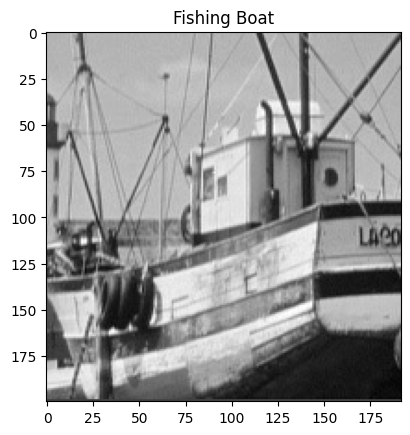

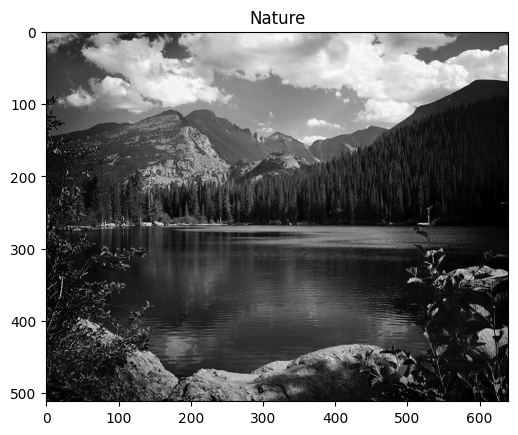

In [409]:
#display images in grayscale
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
plt.imshow(img1_gray, cmap='gray', vmin=0, vmax=255)
plt.title('Fishing Boat')
plt.show()

img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
plt.imshow(img2_gray, cmap='gray', vmin=0, vmax=255)
plt.title('Nature')
plt.show()

In [455]:
def plot_chip(chip):
    plt.imshow(chip, cmap='gray', vmin=0, vmax=255)
    plt.colorbar()
    plt.show()

def plot_corrupted_chip(chip,s,image_name):
    # Generate a masked array where True indicates a NaN (corrupted) value
    masked_array = np.ma.array(chip, mask=np.isnan(chip))
    # Plot the corrupted chip with red for NaNs
    cmap = plt.cm.gray
    cmap.set_bad('red', 1)
    plt.title('Corrupted Chip for '+ image_name +' with S = ' + str(s))
    plt.imshow(masked_array, cmap=cmap, interpolation= 'none', vmin=0, vmax=255)
    #plt.colorbar()
    plt.show()

def corrupt_chip(chip, S, block_size):
    # Convert chip to float type to support NaN
    chip = chip.astype(float)
    # Total pixels in the block
    total_pixels = len(chip.flatten())
    # Ensure S is within the possible range
    S = max(0, min(S, total_pixels))
    # Corrupt (total_pixels - S) pixels
    corrupt_indices = np.random.choice(total_pixels, total_pixels - S, replace=False)
    for index in corrupt_indices:
        x, y = divmod(index, block_size)
        chip[x, y] = np.nan  # Set the pixel to NaN
        
    return chip

# Display the block (chip) with the top-left pixel at (x, y) = (x∗, y∗) for each image
def generate_chips(image, block_size):
    chip_list = []
    X_SHAPE, Y_SHAPE = image.shape
    print("Image shape: ", X_SHAPE, Y_SHAPE)
    # Iterate over image for blocks of size CHIP_SIZE:
    for x in range(0, X_SHAPE, block_size):
        for y in range(0, Y_SHAPE, block_size):
            chip = image[x:x+block_size,y:y+block_size]
            chip_list.append(chip)
    return chip_list

# Combine the reconstructed chips into a single image
def reconstruct_image(image, chip_list,block_size):
    reconstructed_image = np.zeros(image.shape)
    chip_index = 0
    for x in range(0, image.shape[0], block_size):
        for y in range(0, image.shape[1], block_size):
            reconstructed_image[x:x+block_size, y:y+block_size] = chip_list[chip_index].reshape((block_size, block_size))
            chip_index += 1

    return reconstructed_image

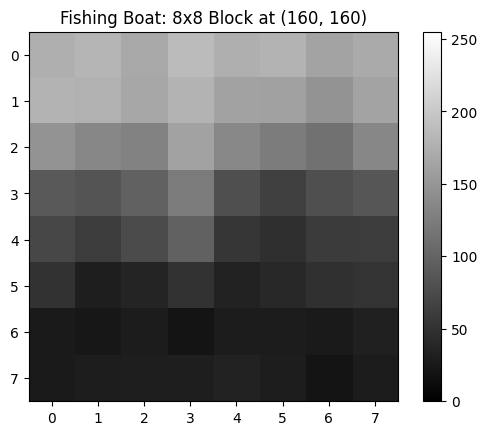

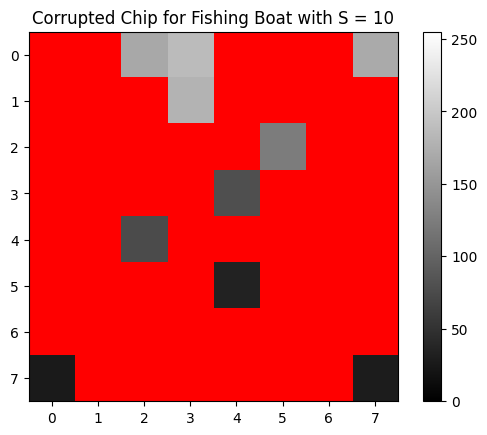

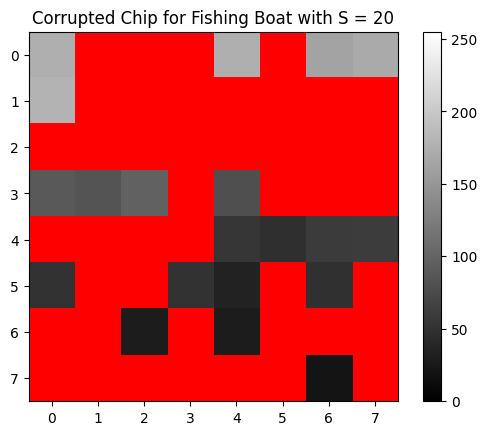

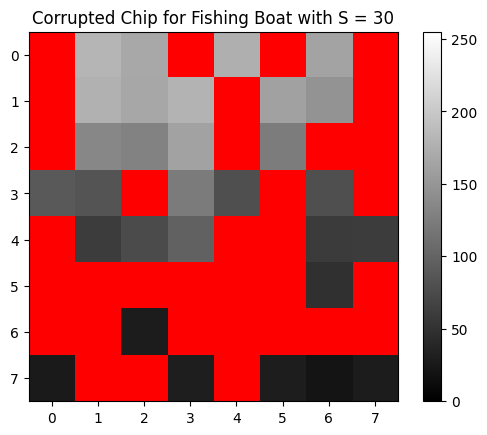

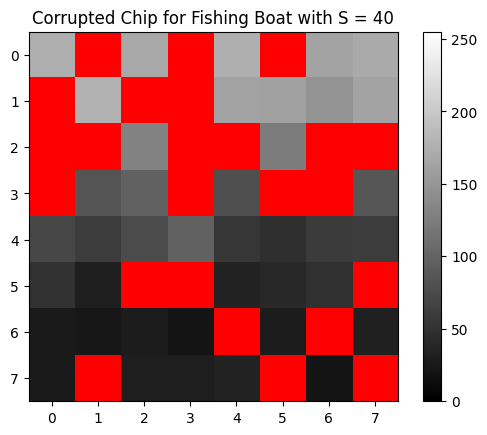

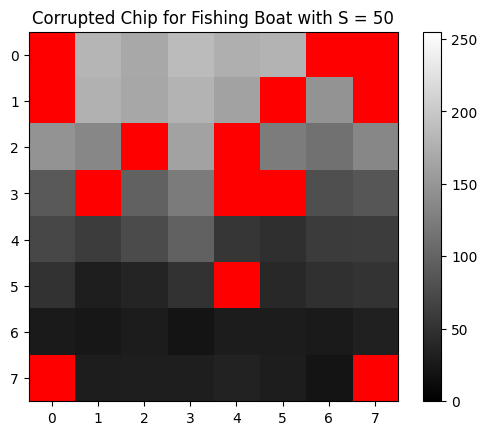

In [411]:
#fishing boat block corruption
x_star = 160
y_star = 160
x_star = x_star - 1
y_star = y_star - 1
chip1 = img1_gray[x_star:x_star+8,y_star:y_star+8]
S= [10, 20, 30, 40, 50]
plt.title(f"Fishing Boat: 8x8 Block at ({160}, {160})")
plot_chip(chip1)
# plot lengend from 0 to 255
# plt.show()
for s in S:
    corrupt_chip1 = corrupt_chip(chip1, s,8)
    plot_corrupted_chip(corrupt_chip1,s,image_name='Fishing Boat')

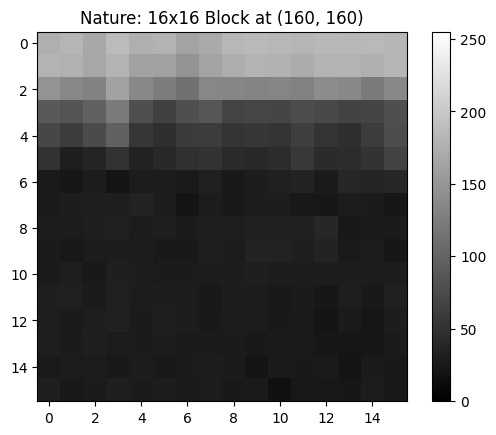

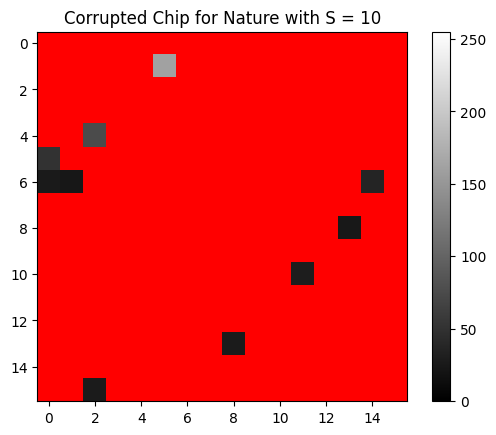

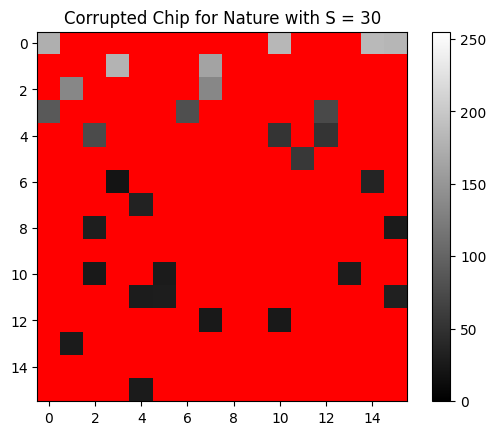

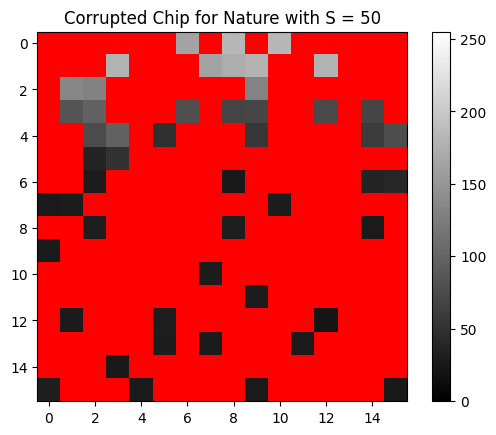

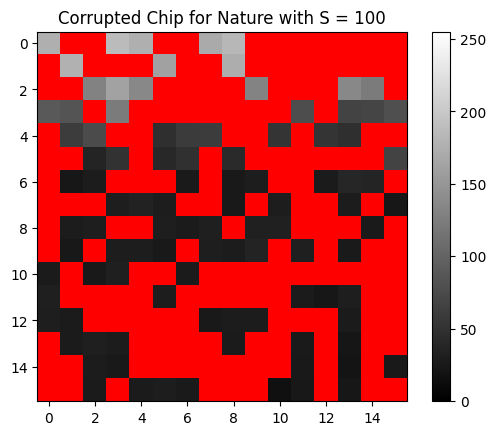

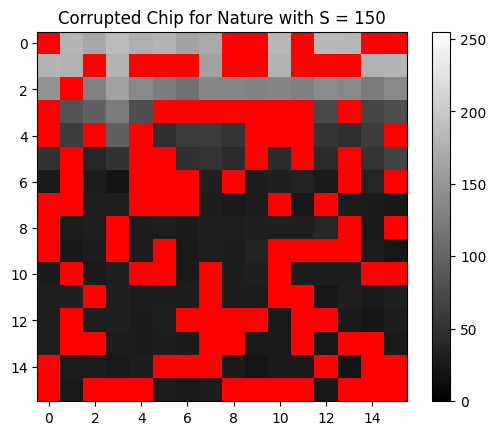

In [412]:
#corruption block for nature image
x_star = 160
y_star = 160
x_star = x_star - 1
y_star = y_star - 1
chip2 = img1_gray[x_star:x_star+16,y_star:y_star+16]
S= [10, 30, 50, 100, 150]
plt.title(f"Nature: 16x16 Block at ({160}, {160})")
plot_chip(chip2)
#plot lengend from 0 to 255
# plt.show()
for s in S:
    corrupt_chip1 = corrupt_chip(chip2, s,16)
    plot_corrupted_chip(corrupt_chip1,s,'Nature')

In [413]:
def get_chip_list_and_corrupted_chip_list(image, S,block_size):
    chip_list = generate_chips(image, block_size)
    corrupted_chip_list = [corrupt_chip(chip, S,block_size) for chip in chip_list]

    return chip_list, corrupted_chip_list

def rasterize_matrix(matrix):
    return matrix.flatten()

def create_basis_chip(P, Q, u, v):
    # Adjust alpha and beta for one-based indexing
    alpha_u = np.sqrt(1.0 / P) if u == 1 else np.sqrt(2.0 / P)
    beta_v = np.sqrt(1.0 / Q) if v == 1 else np.sqrt(2.0 / Q)
    # Create the basis chip for the given u, v using one-based indexing
    basis_chip = np.zeros((P, Q))
    for x in range(1, P + 1):
        for y in range(1, Q + 1):
            basis_chip[x - 1, y - 1] = (
             alpha_u * beta_v *
                np.cos(np.pi * ((2*x)-1) * (u - 1) / (2.0 * P)) *
                np.cos(np.pi * ((2 *y)-1) * (v - 1) / (2.0 * Q))
            )
    return basis_chip

def create_basis_vector_matrix(block_size):
    num_chips = block_size * block_size
    basis_vector_matrix = np.zeros((num_chips, num_chips))
    # Filling the basis vector matrix
    for u in range(1, block_size + 1):
        for v in range(1, block_size + 1):
            # Create basis chip for each (u, v) pair using one-based indexing
            basis_chip = create_basis_chip(block_size, block_size, u, v)
            # Flatten the basis chip to be a column in the basis vector matrix
            column_index = (u - 1) * block_size + (v - 1)
            basis_vector_matrix[:, column_index] = basis_chip.flatten('F')

    return basis_vector_matrix


In [414]:
def flatten_and_mask(chip):
    flat_chip = chip.flatten()
    mask = ~np.isnan(flat_chip)
    return flat_chip[mask][:,], mask

def get_w0(c,b):
    w0=(c/b[0])
    return w0

def lasso_cross_validation(num_subsets, lambda_range, sensed_basis_matrix, flattened_chip,s_value,FOR_INERCEPT):
    mse_per_lambda = {alpha: [] for alpha in lambda_range}
    for alpha in lambda_range:
        m = math.floor(s_value/6)
        for _ in range(num_subsets):
            test_index = random.sample(range(s_value), m)
            train_index = [i for i in range(s_value) if i not in test_index]
            #X_train, X_test, y_train, y_test = train_test_split(sensed_basis_matrix, flattened_chip, test_size=m, random_state=cv)
            X_train, X_test = sensed_basis_matrix[train_index], sensed_basis_matrix[test_index]
            y_train, y_test = flattened_chip[train_index], flattened_chip[test_index]   
            model = Lasso(alpha=alpha, max_iter=1000, fit_intercept=True)
            model.fit(X_train[:,1:], y_train)
            model.intercept_ = model.intercept_/FOR_INERCEPT
            dct_coeff=np.array(model.coef_)
            dct_coeff=np.insert(dct_coeff,0,model.intercept_)
            y_pred = np.dot(X_test,dct_coeff)
            mse = mean_squared_error(y_test, y_pred)
            mse_per_lambda[alpha].append(mse)

    avg_mse_per_lambda = {alpha: np.mean(mse) for alpha, mse in mse_per_lambda.items()}

    return avg_mse_per_lambda, dct_coeff, model


In [415]:
# Define your LAMBDA_RANGE globally
LAMBDA_RANGE = np.logspace(-3, 7, 100)
def plot_mse_vs_lambda(avg_mse_per_lambda):
    lambda_values = list(avg_mse_per_lambda.keys())
    mse_values = list(avg_mse_per_lambda.values())

    plt.figure(figsize=(10, 6))
    plt.plot(lambda_values, mse_values)
    plt.xscale('log')
    plt.xlabel('Lambda (Regularization parameter)')
    plt.ylabel('Average Mean Squared Error')
    plt.title('MSE per Lambda in Lasso Regression')
    plt.grid(True)
    plt.show()

def get_reconstructed_chip_list(corrupted_chip_list, block_size,S,num_subsets=20):
    reconstructed_chip_list = []
    basis_vector_matrix = create_basis_vector_matrix(block_size)
    FOR_INERCEPT = basis_vector_matrix[0,0]
    optimal_lambda_for_plot_list = []

    for corrupt_chip in corrupted_chip_list:
        flattened_chip, mask = flatten_and_mask(corrupt_chip)
        sensed_basis_matrix = basis_vector_matrix[mask, :]
        not_sensed_mask = ~mask
        not_sensed_basis_matrix = basis_vector_matrix[not_sensed_mask, :]

        # Run cross-validation on multiple subsets to determine the best lambda
        avg_mse_per_lambda, _, _ = lasso_cross_validation(num_subsets, LAMBDA_RANGE, sensed_basis_matrix, flattened_chip,S,FOR_INERCEPT)
        #plot_mse_vs_lambda(avg_mse_per_lambda)
        # Find the lambda with the lowest average MSE
        optimal_lambda = LAMBDA_RANGE[np.argmin(avg_mse_per_lambda)]
        optimal_lambda_for_plot = min(avg_mse_per_lambda, key=avg_mse_per_lambda.get)
        optimal_lambda_for_plot_list.append(optimal_lambda_for_plot)

        # Now run LASSO with the optimal lambda to get the DCT coefficients
        
        model = Lasso(alpha=optimal_lambda, max_iter=1000, fit_intercept=True)
        model.fit(sensed_basis_matrix[:,1:], flattened_chip)
        model.intercept_ = model.intercept_/FOR_INERCEPT
        dct_coeff=np.array(model.coef_)
        dct_coeff=np.insert(dct_coeff,0,model.intercept_)

        # Reconstruct the non-sensed part of the chip
        reconstructed_non_sensed = np.dot(not_sensed_basis_matrix,dct_coeff)
        
        # Combine sensed and non-sensed parts to get the full reconstruction
        reconstructed_chip_full = np.zeros(flattened_chip.size + not_sensed_mask.sum())
        reconstructed_chip_full[mask] = flattened_chip
        reconstructed_chip_full[not_sensed_mask] = reconstructed_non_sensed
        
        # Reshape to the original chip shape
        reconstructed_chip = reconstructed_chip_full.reshape(corrupt_chip.shape)
        reconstructed_chip_list.append(reconstructed_chip)

    return reconstructed_chip_list, optimal_lambda_for_plot_list

In [416]:
def calculate_mse(image_a, image_b):
    """Calculate the Mean Squared Error between two images."""
    return mean_squared_error(image_a, image_b)

In [453]:
def compare_images(source_image,block_size,S_values,image_name):
    MSE_before_filtering = []
    MSE_after_filtering = []
    for S in S_values:
        chip_list, corrupted_chip_list = get_chip_list_and_corrupted_chip_list(source_image, S,block_size)
        reconstructed_chip_list, optimal_lamda_list = get_reconstructed_chip_list(corrupted_chip_list,block_size, S)
        # Pixel intensity = log 10 of the optimal lambda value
        optimal_lamda_list = np.log10(optimal_lamda_list)

        # Using source_image dimensions, plot a heatmap of the optimal lambda values
        optimal_lambda_heatmap = np.zeros(source_image.shape)
        chip_index = 0
        for x in range(0, source_image.shape[0], block_size):
            for y in range(0, source_image.shape[1], block_size):
                optimal_lambda_heatmap[x:x+block_size, y:y+block_size] = optimal_lamda_list[chip_index]
                chip_index += 1
        plt.figure(figsize=(15, 5))
        plt.imshow(optimal_lambda_heatmap, cmap='gray', vmin=min(optimal_lamda_list), vmax=max(optimal_lamda_list))
        plt.colorbar()
        plt.title(f'Optimal Lambda Heatmap for {image_name} with S = {S}')
        plt.show()

        # Create image from corrupted_chip_list
        corrupted_image = reconstruct_image(source_image, corrupted_chip_list,block_size)
        #number of nan in corrupted image
        nan_count = np.count_nonzero(np.isnan(corrupted_image))
        print(f'Number of NaNs in corrupted image for {image_name} with S = {S}: {nan_count}')
        print(f'Percentage of NaNs in corrupted image for {image_name} with S = {S}: {nan_count / (source_image.shape[0] * source_image.shape[1]) * 100:.2f}%')
        
        #Create image from reconstructed_chip_list
        reconstructed_image = reconstruct_image(source_image, reconstructed_chip_list,block_size)
        #Apply median filter to the reconstructed image
        filtered_image = medfilt(reconstructed_image, kernel_size=3)
        #Calculate mse
        mse_before = calculate_mse(source_image, reconstructed_image)
        mse_after = calculate_mse(source_image, filtered_image)
        MSE_before_filtering.append(mse_before)
        MSE_after_filtering.append(mse_after)

        # Display the original, corrupted, and reconstructed images
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 2, 1)
        plt.title(f'Original Image for {image_name}')
        plot_chip(source_image)
        
        plt.figure(figsize=(15, 15))
        plt.subplot(1, 2, 2)
        plot_corrupted_chip(corrupted_image,S,image_name)
        plt.show()

        plt.figure(figsize=(15, 5))
        plt.subplot(1, 2, 1)
        plt.title(f'Reconstructed Image without median filtering for {image_name} with S = {S} and MSE = {mse_before}', fontsize=8)
        plot_chip(reconstructed_image)
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 2, 2)
        plt.title(f'Reconstructed Image with median filtering for {image_name} with S = {S} and MSE = {mse_after}', fontsize=8)
        plot_chip(filtered_image)

    plt.figure(figsize=(10, 6))
    plt.plot(S_values, MSE_before_filtering, label='Before Median Filtering', marker='o')
    plt.plot(S_values, MSE_after_filtering, label='After Median Filtering', marker='x')
    plt.title('MSE vs. Number of Sensed Pixels (S)')
    plt.xlabel('Number of Sensed Pixels (S)')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()


'Fish Boat Image Reconstruction using LASSO Regression'

Image shape:  200 192


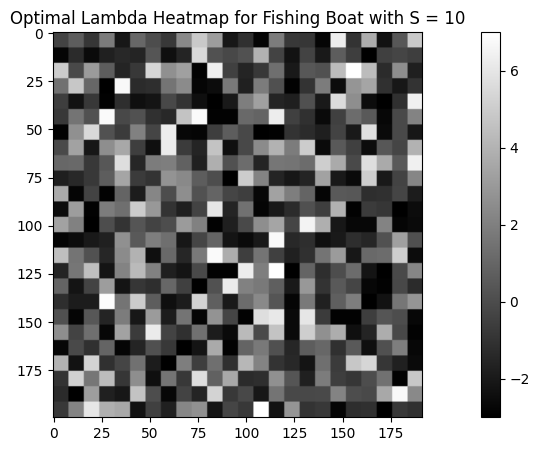

Number of NaNs in corrupted image for Fishing Boat with S = 10: 32400
Percentage of NaNs in corrupted image for Fishing Boat with S = 10: 84.38%


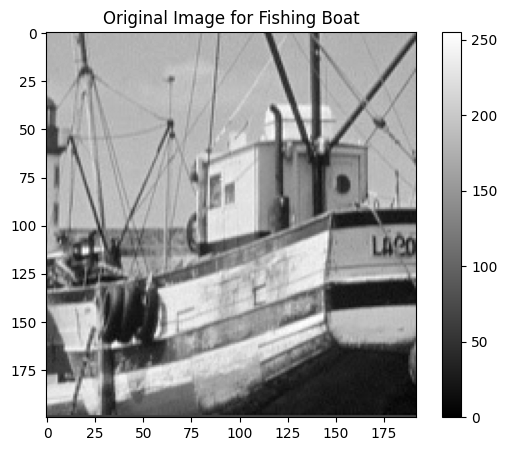

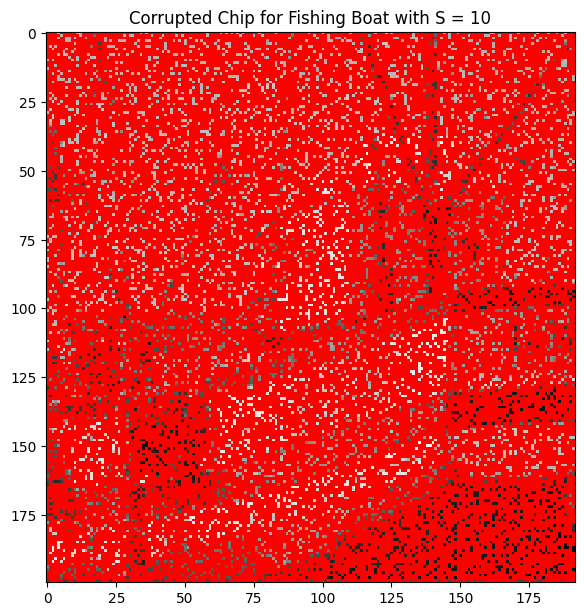

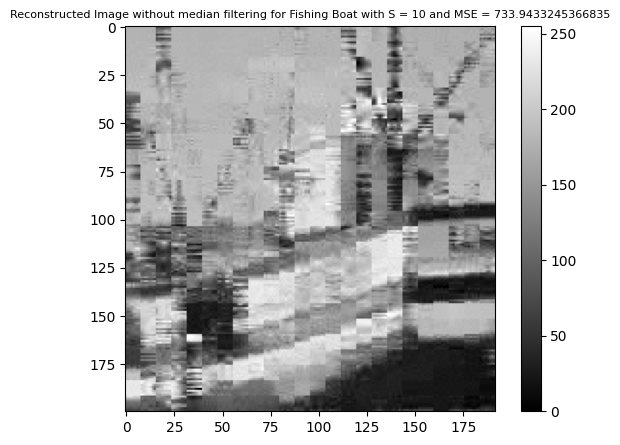

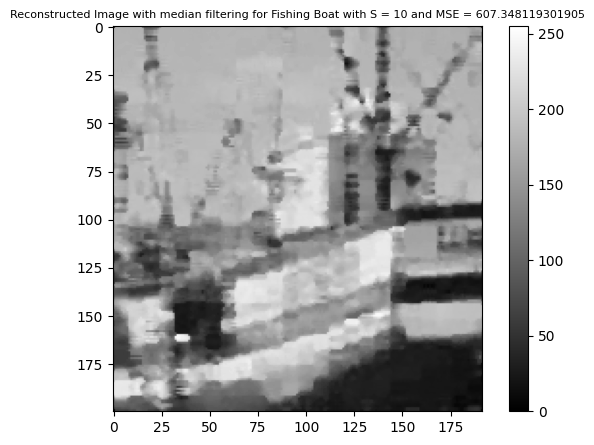

Image shape:  200 192


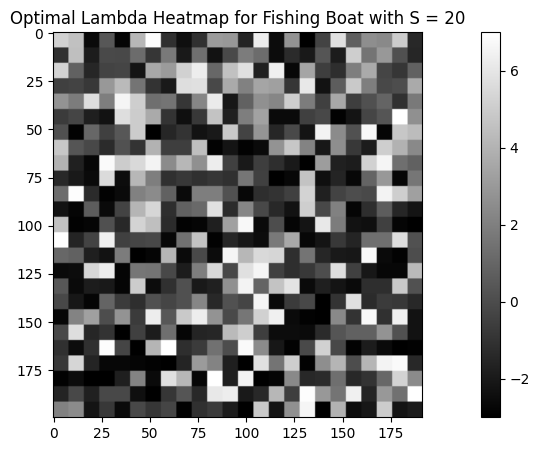

Number of NaNs in corrupted image for Fishing Boat with S = 20: 26400
Percentage of NaNs in corrupted image for Fishing Boat with S = 20: 68.75%


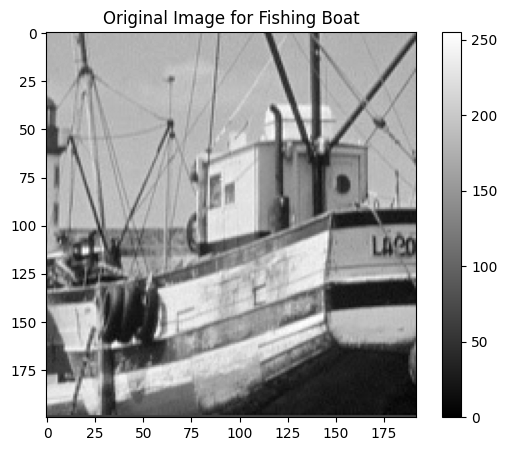

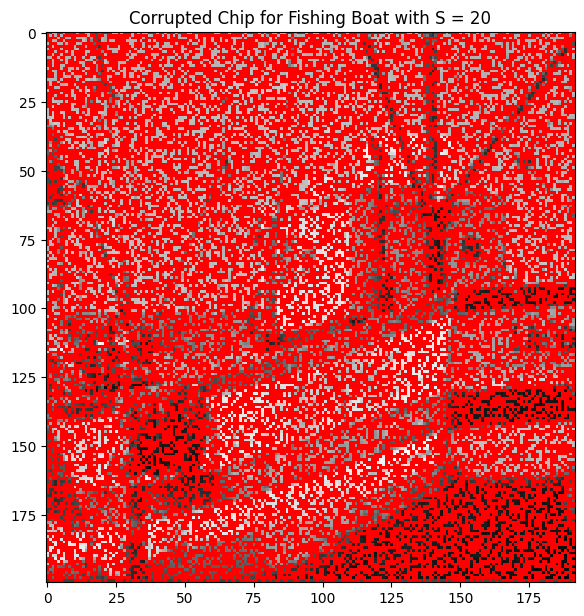

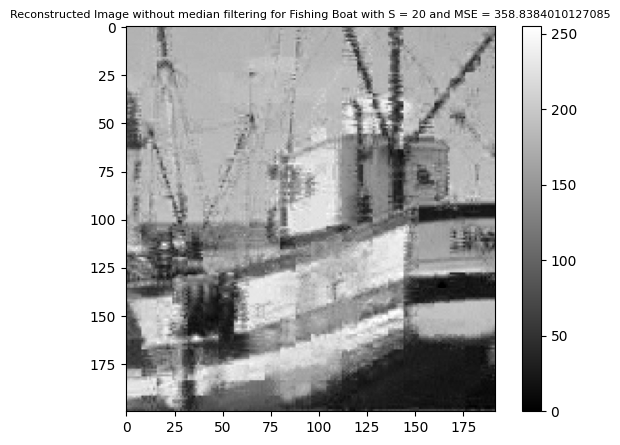

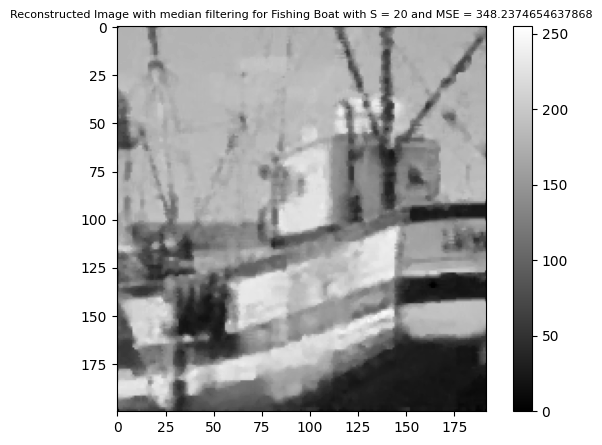

Image shape:  200 192


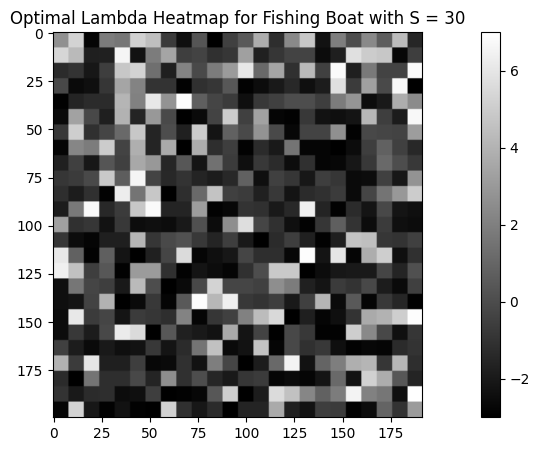

Number of NaNs in corrupted image for Fishing Boat with S = 30: 20400
Percentage of NaNs in corrupted image for Fishing Boat with S = 30: 53.12%


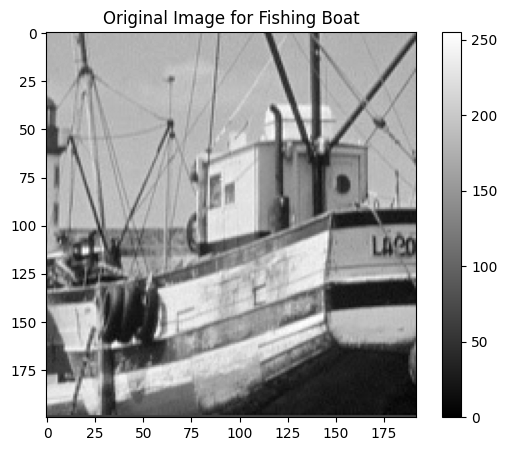

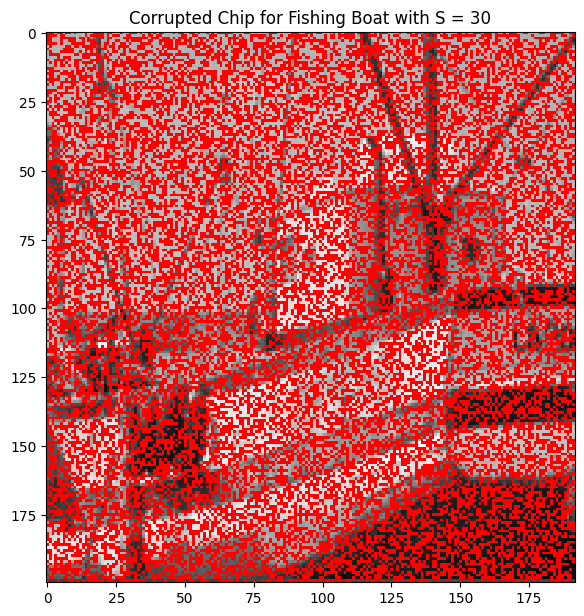

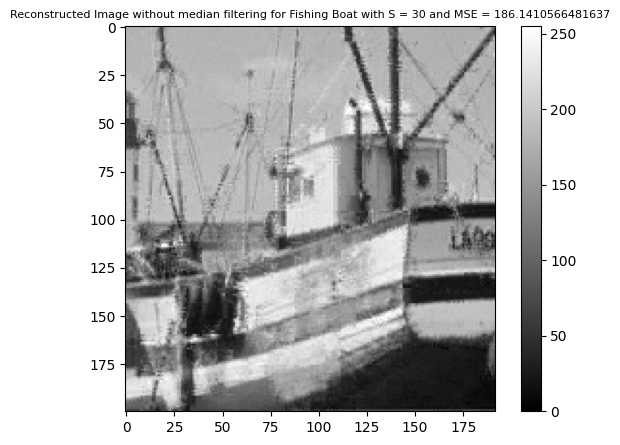

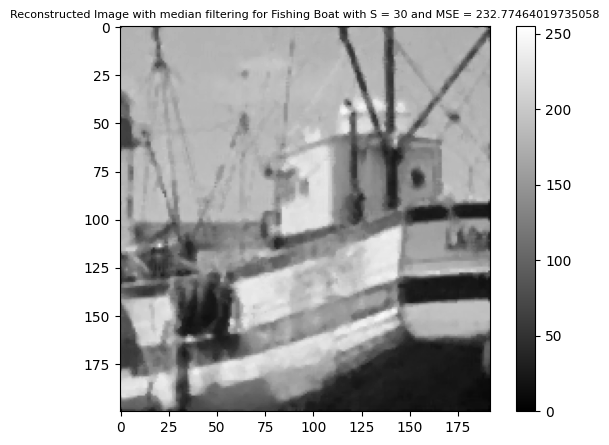

Image shape:  200 192


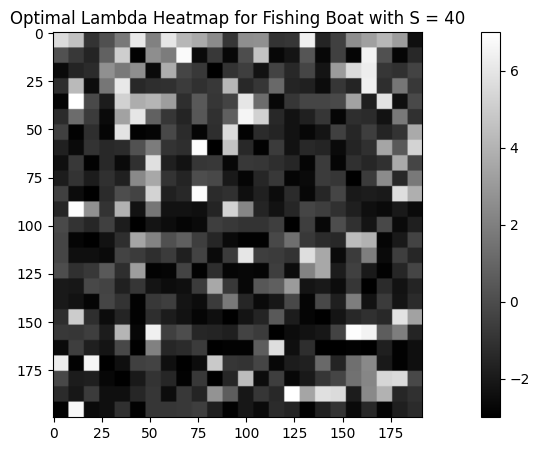

Number of NaNs in corrupted image for Fishing Boat with S = 40: 14400
Percentage of NaNs in corrupted image for Fishing Boat with S = 40: 37.50%


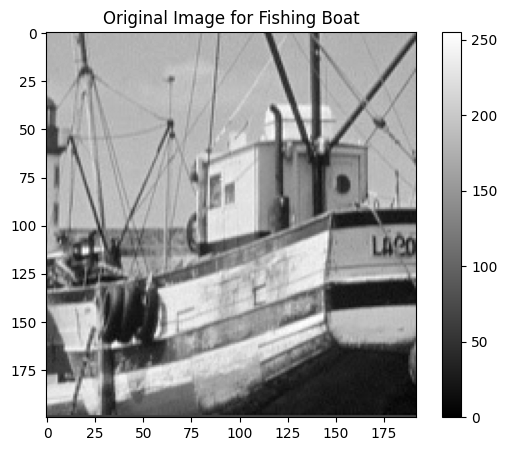

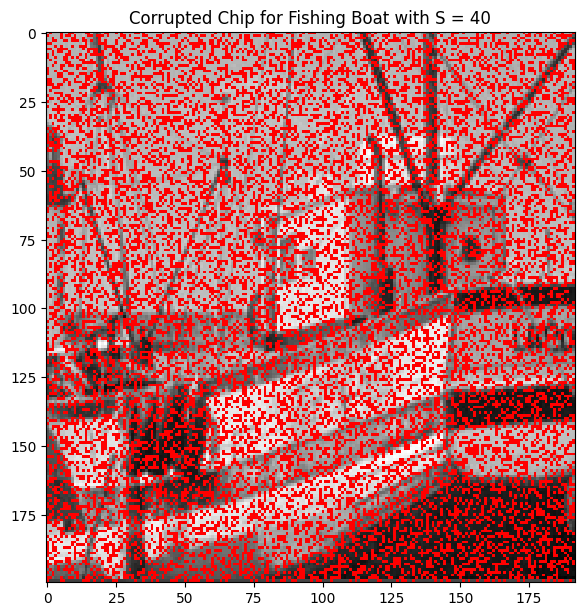

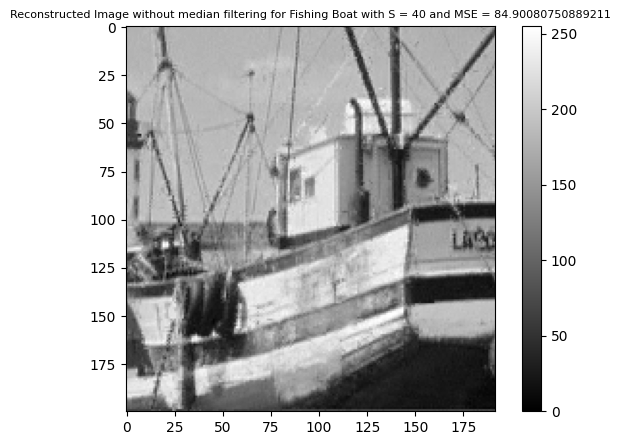

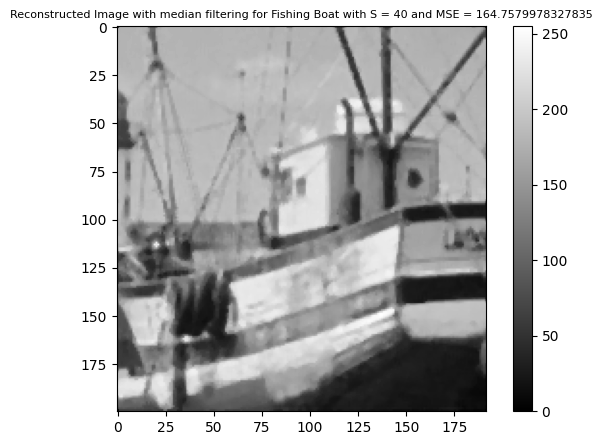

Image shape:  200 192


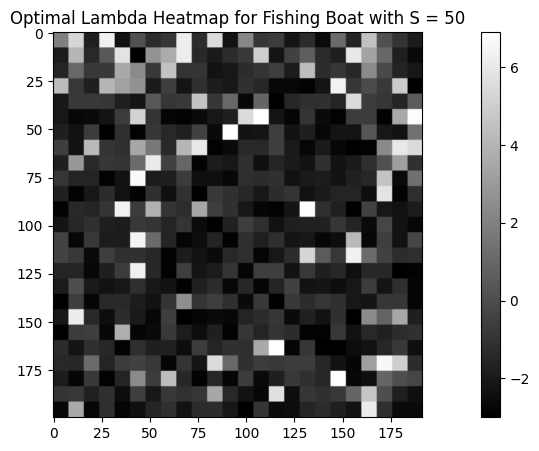

Number of NaNs in corrupted image for Fishing Boat with S = 50: 8400
Percentage of NaNs in corrupted image for Fishing Boat with S = 50: 21.88%


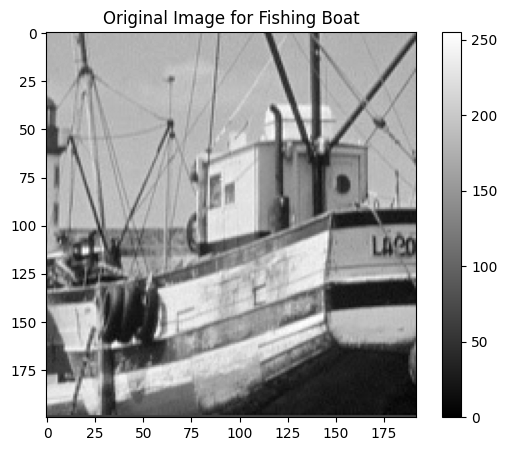

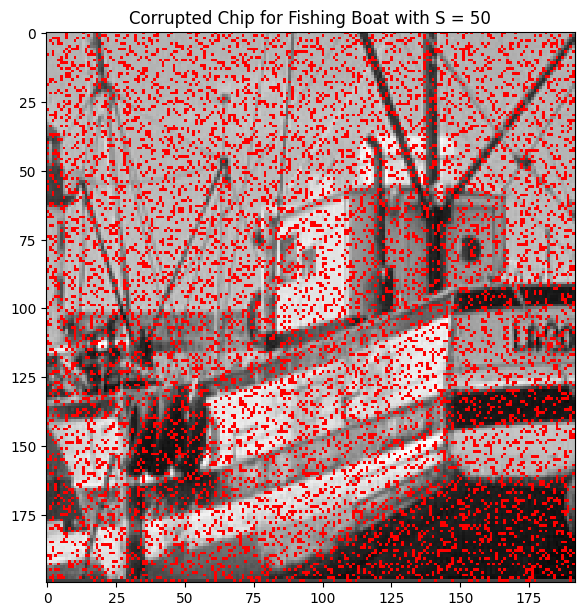

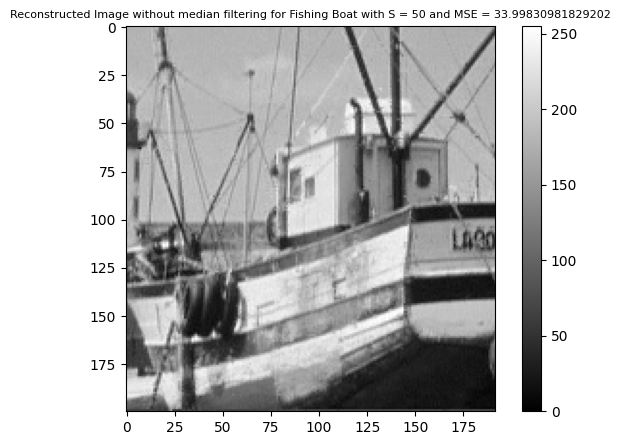

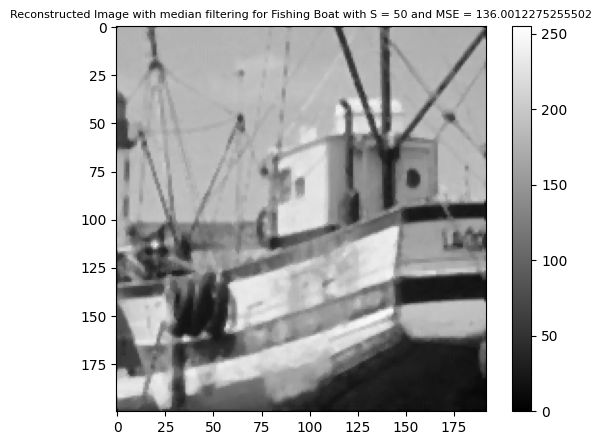

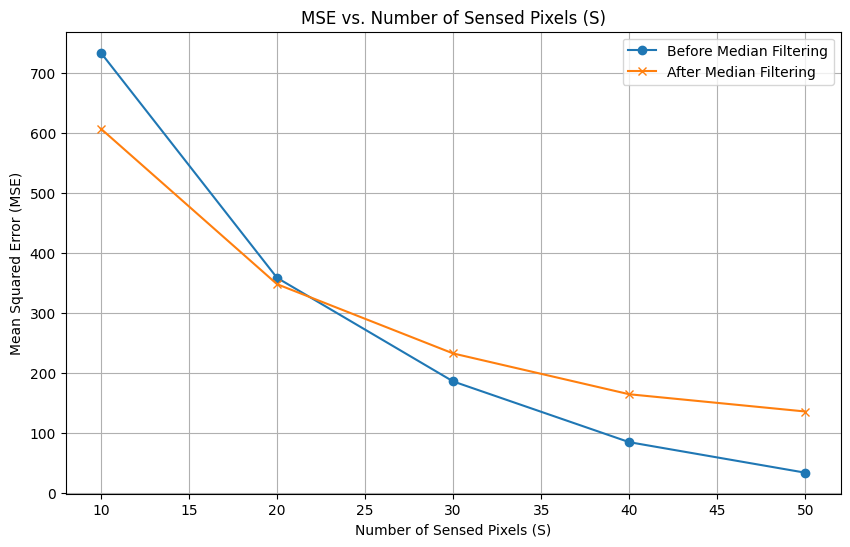

In [456]:
display("Fish Boat Image Reconstruction using LASSO Regression")
compare_images(img1_gray,block_size=8,S_values = [10,20,30,40,50],image_name='Fishing Boat')

'Nature Image Reconstruction using LASSO Regression'

Image shape:  512 640


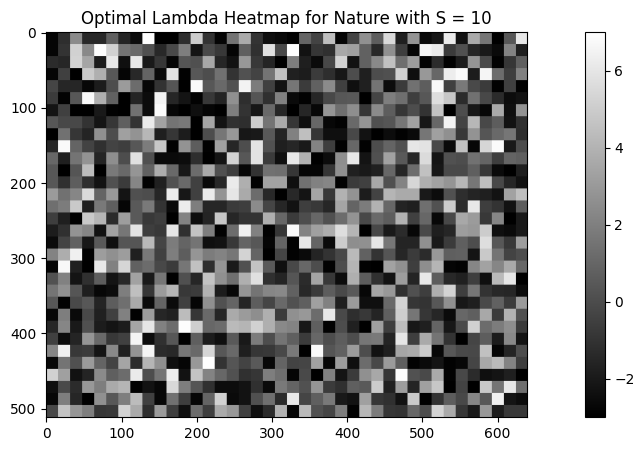

Number of NaNs in corrupted image for Nature with S = 10: 314880
Percentage of NaNs in corrupted image for Nature with S = 10: 96.09%


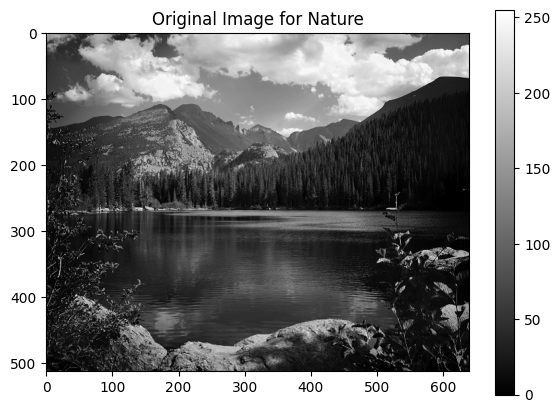

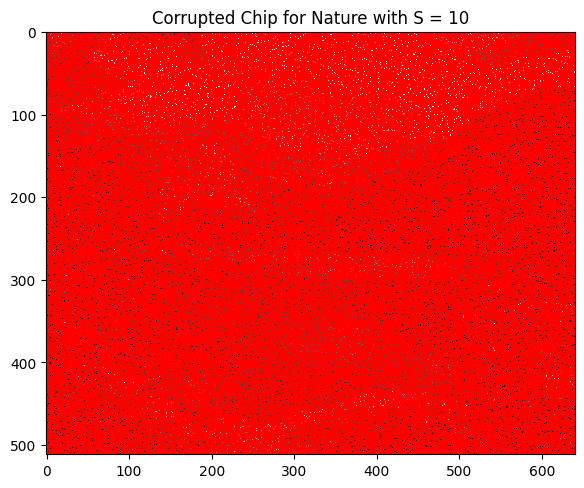

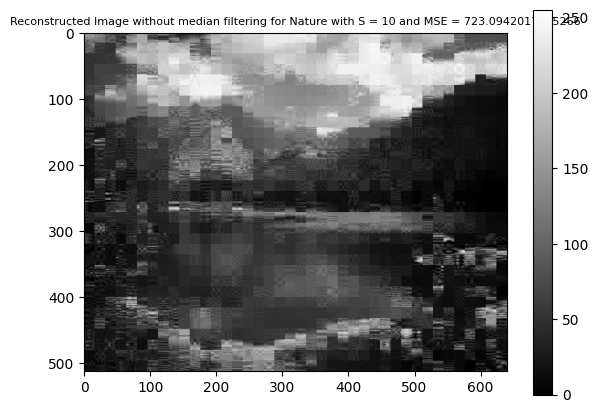

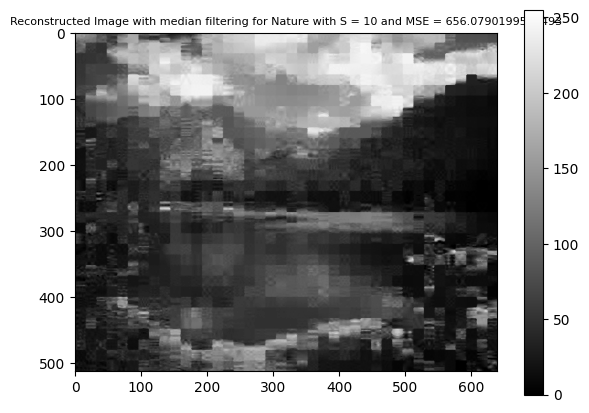

Image shape:  512 640


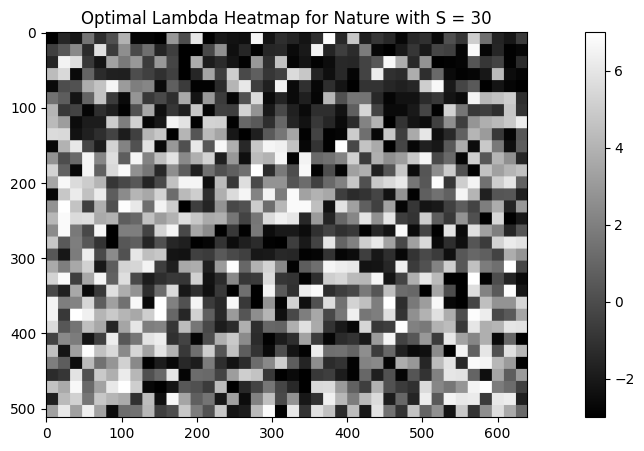

Number of NaNs in corrupted image for Nature with S = 30: 289280
Percentage of NaNs in corrupted image for Nature with S = 30: 88.28%


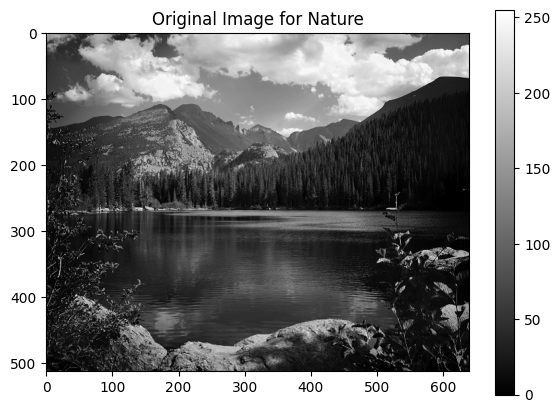

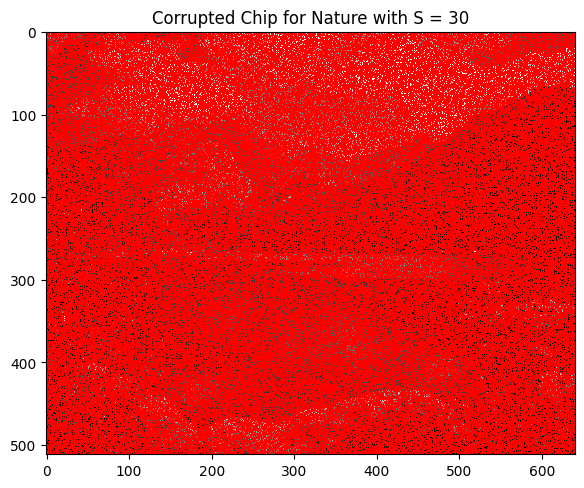

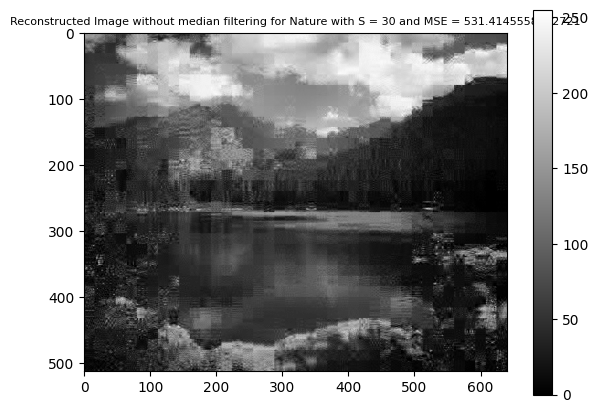

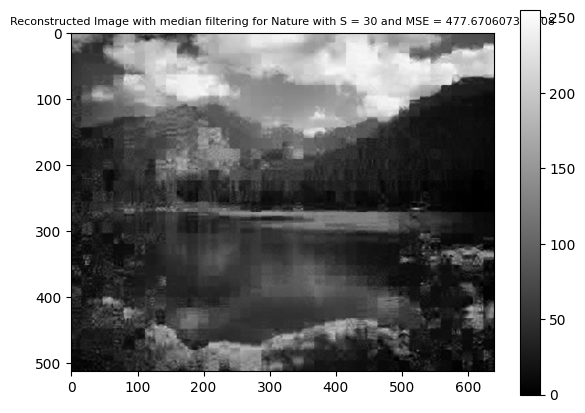

Image shape:  512 640


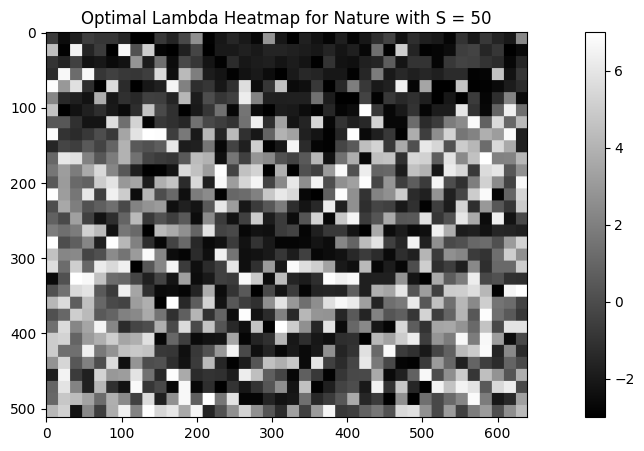

Number of NaNs in corrupted image for Nature with S = 50: 263680
Percentage of NaNs in corrupted image for Nature with S = 50: 80.47%


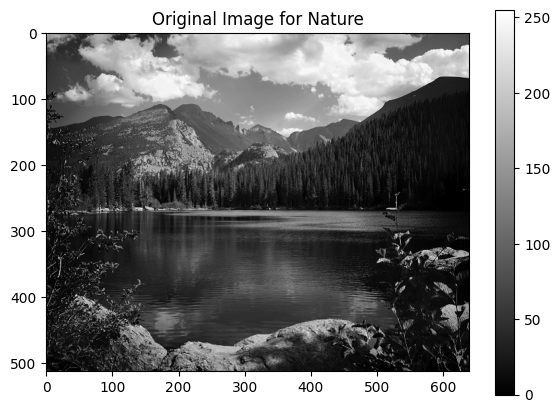

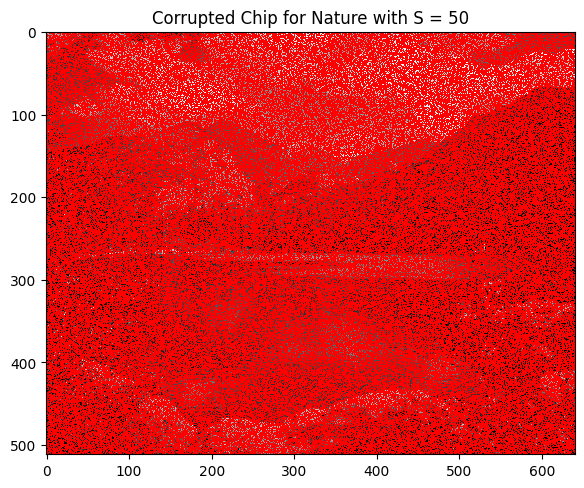

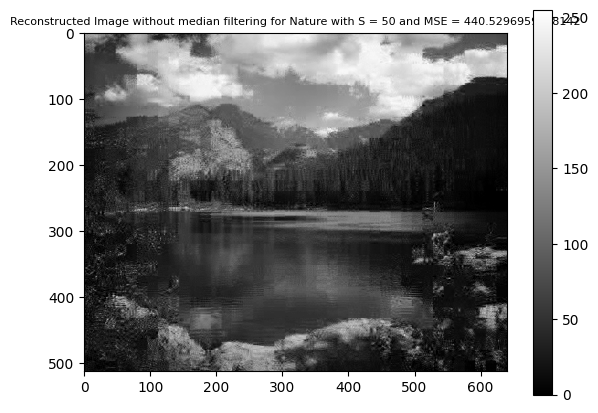

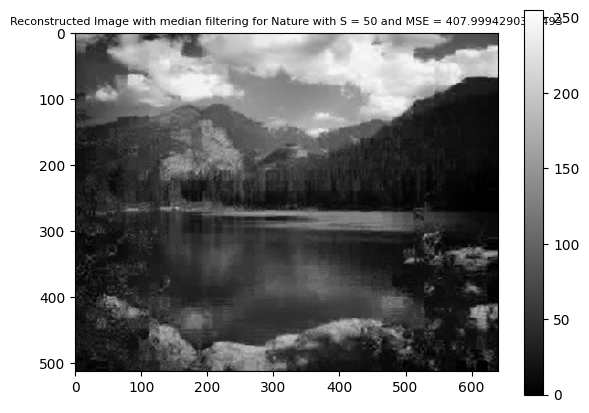

Image shape:  512 640


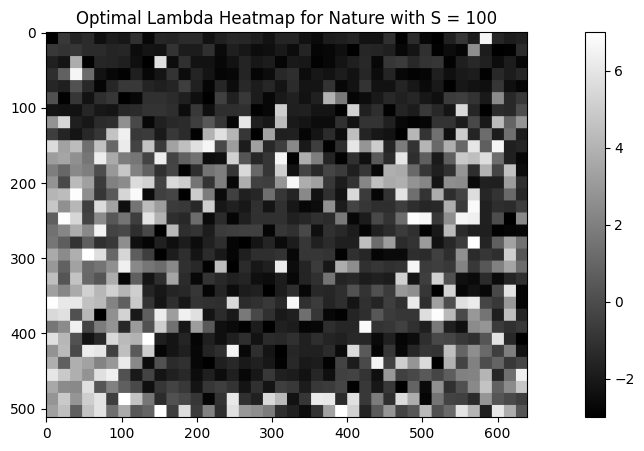

Number of NaNs in corrupted image for Nature with S = 100: 199680
Percentage of NaNs in corrupted image for Nature with S = 100: 60.94%


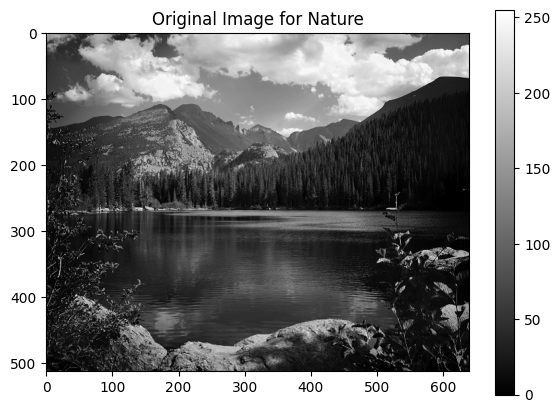

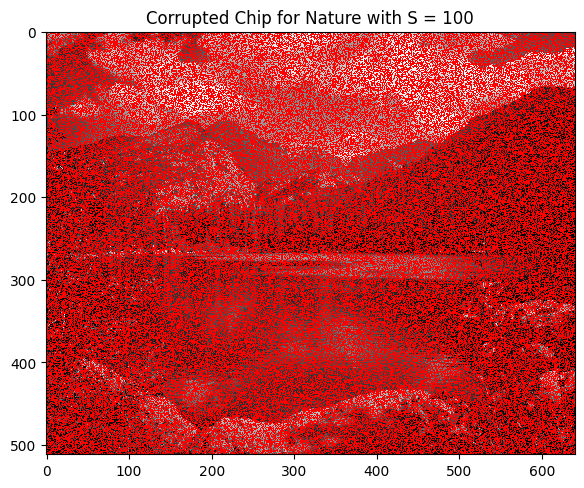

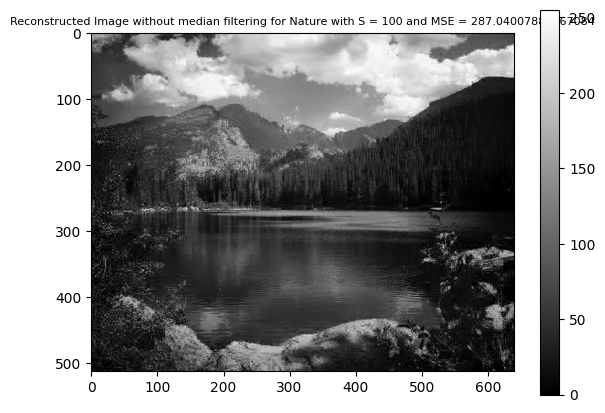

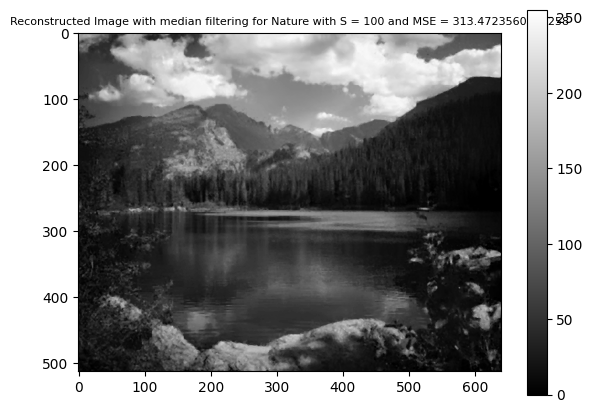

Image shape:  512 640


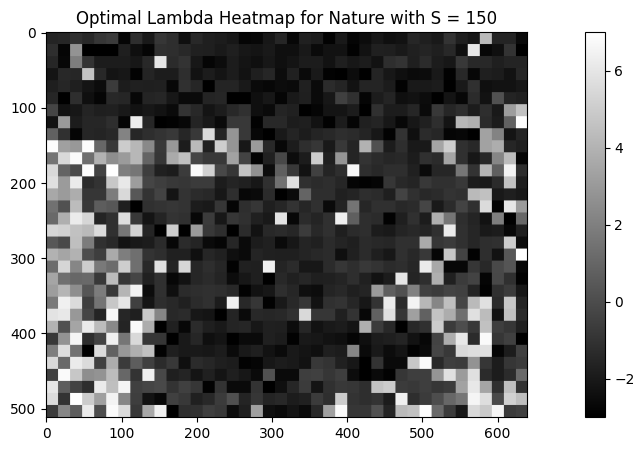

Number of NaNs in corrupted image for Nature with S = 150: 135680
Percentage of NaNs in corrupted image for Nature with S = 150: 41.41%


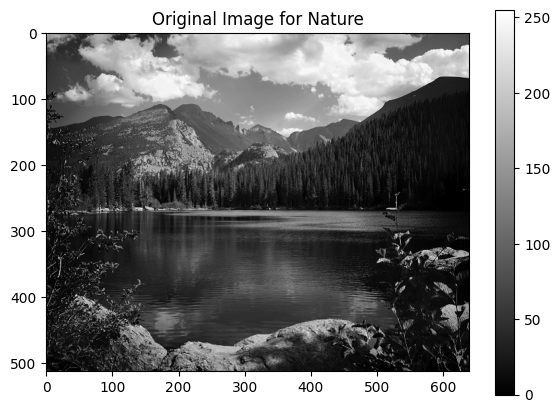

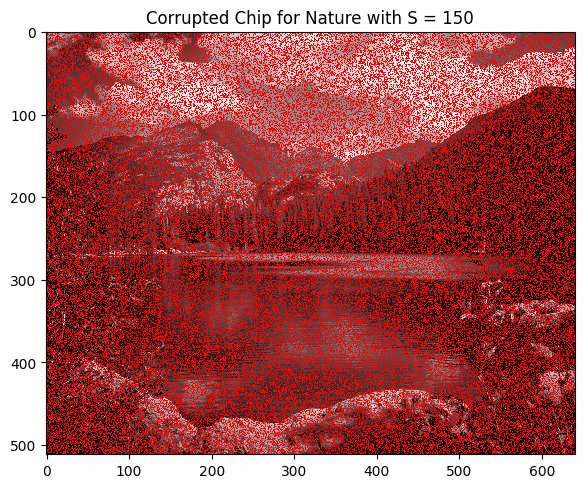

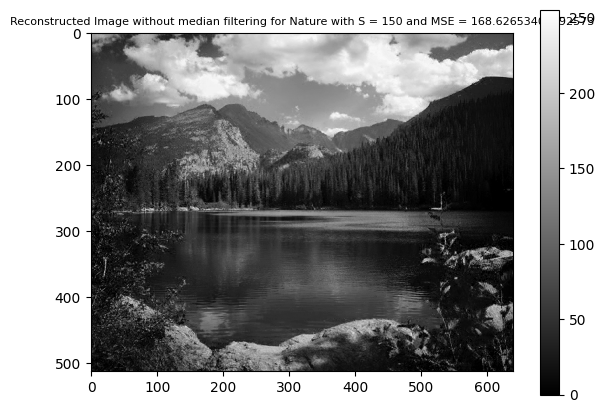

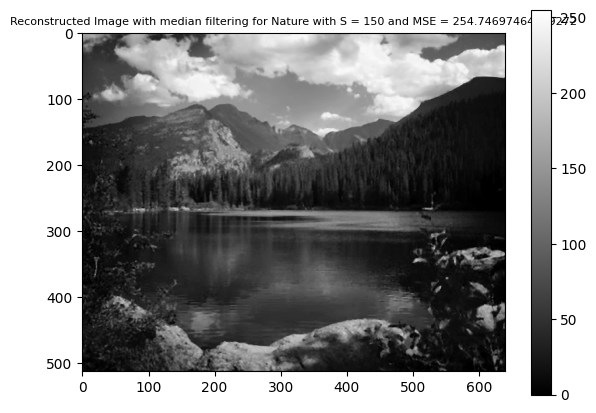

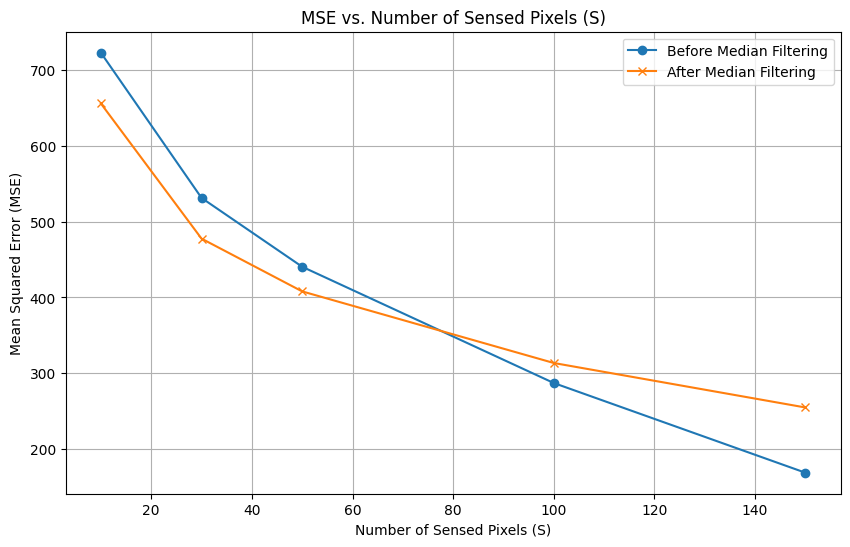

In [457]:
display("Nature Image Reconstruction using LASSO Regression")
compare_images(img2_gray,block_size=16,S_values = [10,30,50,100,150],image_name='Nature')

[nan 88. nan ... nan nan nan]
(98304,)


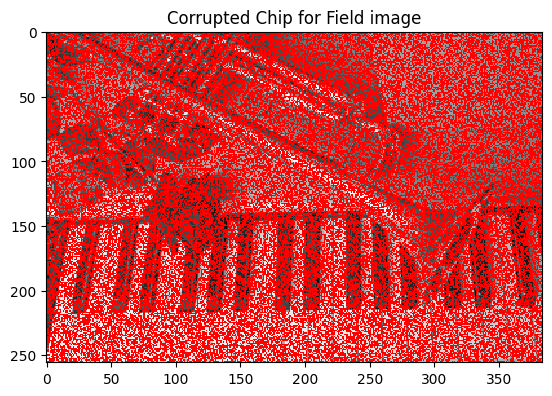

In [458]:
import matplotlib.pyplot as plt

# Convert text file content into a numpy array of pixel values
def read_image_from_text_file(filename):
    pixel_values = np.array([])
    with open(filename, 'r') as file:
        data = file.read()
        data = data.replace("\n", ",")
        words = data.split(",")
        for word in words:
            word = word.strip().lower()
            if "nan" in word:
                pixel_values = np.append(pixel_values, np.nan)
            elif word != "":
                pixel_values = np.append(pixel_values, int(word))
    
    print(pixel_values)
    print(pixel_values.shape)
    # Convert the pixel values to a 2D array
    image = pixel_values.reshape((256, 384))

    #  Display the image
    masked_array = np.ma.array(image, mask=np.isnan(image))
    # Plot the corrupted chip with red for NaNs
    cmap = plt.cm.gray
    cmap.set_bad('red', 1)
    plt.title('Corrupted Chip for Field image')
    plt.imshow(masked_array, cmap=cmap, interpolation= 'none', vmin=0, vmax=255)
    plt.show()
    return image

# Read the image from the text file
field_test_image = read_image_from_text_file('testimages/field_test_image.txt')
#find number of nan values in the image
nan_values = np.isnan(field_test_image)
nan_count = np.sum(nan_values)
not_nan_count = np.sum(~nan_values)

Image shape:  256 384


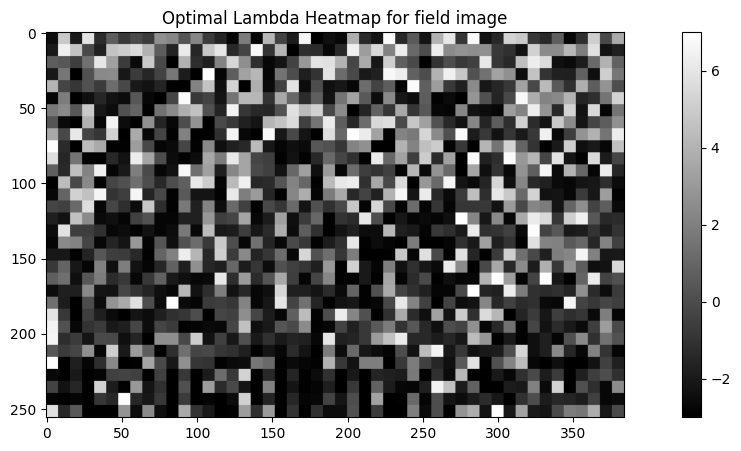

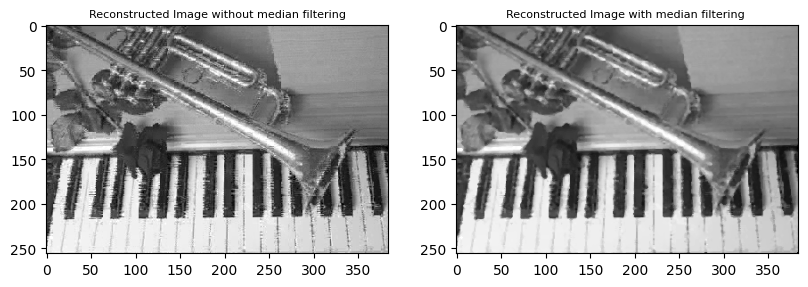

In [421]:
chip_list = generate_chips(field_test_image,block_size=8)
reconstructed_chip_list, optimal_lambda_list = get_reconstructed_chip_list(chip_list,block_size=8,S=12)
reconstructed_image = reconstruct_image(field_test_image, reconstructed_chip_list,block_size=8)
filtered_image = medfilt(reconstructed_image, kernel_size=3)

optimal_lamda_list = np.log10(optimal_lambda_list)
# Using source_image dimensions, plot a heatmap of the optimal lambda values
optimal_lambda_heatmap = np.zeros(field_test_image.shape)
chip_index = 0
for x in range(0, field_test_image.shape[0], 8):
    for y in range(0, field_test_image.shape[1], 8):
        optimal_lambda_heatmap[x:x+8, y:y+8] = optimal_lamda_list[chip_index]
        chip_index += 1
plt.figure(figsize=(15, 5))
plt.imshow(optimal_lambda_heatmap, cmap='gray', vmin=min(optimal_lamda_list), vmax=max(optimal_lamda_list))
plt.colorbar()
plt.title(f'Optimal Lambda Heatmap for field image')
plt.show()

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title('Reconstructed Image without median filtering' , fontsize=8)
plt.imshow(reconstructed_image, cmap='gray',vmin=0, vmax=255)
plt.subplot(1, 3, 2)
plt.title('Reconstructed Image with median filtering ' , fontsize=8)
plt.imshow(filtered_image, cmap='gray',vmin=0, vmax=255)
plt.show()